# ELEC 400M / EECE 571M Assignment 1: Linear models for classification
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will be using linear models discussed in the lectures to perform a binary classification task. You will compare the performances of linear classification and logistic regression using suitable training algorithms. The implementation will be done in python using functions from the NumPy library.

## Data Set
We consider the dataset of images of letters contained in file notMNIST.npz. In particular, you will use a smaller dataset that only contains the images from two letter classes: “C” (the positive class) and “J” (the negative class). The images are of size 28 × 28 pixels. The figure below shows 20 randomly selected image samples for the letters “C” and “J”.

![](sample_images.eps)

You will apply the function `loadData` to generate the subset of images containing only letters “C” and “J”. This script organizes the total set of 3,745 images into maller subsets containing 3,500 training images, 100 validation images and 145 test images. Their use will be further specified in the problem descriptions below.

In [88]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [98]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.0
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(1)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Linear Classification

The first classifier is the linear classifier 
$$\hat{y}=\mathrm{sign}\left(\sum_{i=0}^dw_ix_i\right)\,$$
where $x_0=1$ so that $b=w_0x_0$ is the bias term and $x_1,\ldots, x_d$ are the input features.
The loss function for an input-output pair $(\underline{x}_n,y_n)$ and given model parameters $\underline{w}$ is 
$$L_n(\underline{w})= \mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$
The total loss for $N$ samples is 
$$L(\underline{w})= \frac{1}{N}\sum\limits_{n=1}^N\mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$



### Notes on Classification
* The classification should be based on the $d=28\times 28=784$ intensity values in an image. This means that you need to flatten the 2D images to 1D input vectors $\underline{x}$ of length 784.
* The outputs $\hat{y}$ of the perceptron model are from $\{-1,+1\}$, while the target variable from the data set is from $\{0,1\}$. You need to make adjustements to account for this difference, which can include adjusting the data type.

### Loss Function [2 points]

Implement a function to compute the classification loss as defined above. The function has three input arguments: the weight vector, the feature vectors, and the labels. It returns the total loss associated with the input.

In [99]:
def ErrorRate (w, x, y):
    
    N = len(y)
    #initialize y_hat prediction vector
    y_hat = np.zeros((len(y),1))
    
    #loop for error rate
    for i in range(len(y)):
        
        #appending 1 to the beginning of the sample for bias
        x_t = np.append(1,x[i].flatten())
        
        #evaluate y_hat
        y_hat[i] = 1 if (np.dot(x_t,w)) > 0 else 0
    
    #evaluate total loss
    loss = (1/N)*np.sum(y != y_hat) 
    
    return loss

### Perceptron Learning Algorithm [10 points]

Implement a function for the perceptron learning algorithm (PLA) which accepts four arguments: an inital weight vector, the data, the labels, and the maximal number of iterations it executes. It is thus a version of the PLA is assured to terminate. The function returns the updated weight vector. 

In [180]:
def PLA(w, x, y, maxIter):
    
    #get total element
    N = len(y)
    
    #loop for max iterations
    for t in range(maxIter):
        
        #eval y_hat
        for s in range(N):
            
            #flatten for use
            x1 = np.append(1,x[s].flatten())
            
            #prediction
            y_hat = 0 if np.dot(x1,w) < 0 else 1
            
            #if a misclassification
            if (y_hat != y[s]):
                
                #updating the weight vector
                y_n = 1 if y[s] == 1 else -1
                
                #apply the equation
                w = w + y_n * x1
                
                #finish and go to next iterations
                break
        
    return w    


Test the `PLA` function by training the classifier on the training data (`trainData`, `trainTarget`) with a maximum of 100 iterations, and measuring the cassification error using the testing data (`testData`, `testTarget`). Write the test script into the box below and let it print the classiciation error.

In [101]:
#load data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#init weights
w = np.zeros(trainData.shape[1] * trainData.shape[2] + 1)

#train
w_optimal = PLA(w, trainData, trainTarget, 100)

#check training error
print(ErrorRate(w_optimal, trainData, trainTarget))

0.02428571428571429


### Pocket algorithm [14 points]

Implement a function for the pocket algorithm which accepts three arguments: the data, the labels, and the number of iterations it executes. It should use the function `PLA` you developed above. It returns the updated weight vector.

First, briefly describe how your pocket algorithm works, and how it calls the function `PLA` above.

The pocket algorithm works by keeping the best weight vector "in its pocket". It returns the best weight vector from its pocket when the iterations are complete.


The algorithm calls the PLA by passing it the initial weight vector, the parameters matrix, the label vector, and the amount of sufficient iterations. It then adjusts the weights to store in the pocket.

If the new weights produce a smaller number of misclassification than the weights in the pocket, then replace the weights in the pocket to the new weights; else if the new weights are not better than the one in the pocket, keep the weight vector in the pocket and discard the new weights. 

At the end of the training iteration, the algorithm returns the solution in the pocket (w_p), rather than the last solution.



In [102]:
def pocket(x, y, T):
    
    #initialize weights
    dimension = len( trainData[0].flatten() )
    w_t = np.zeros(dimension + 1)
    
    #pocket error - init
    p_loss = 1 
    
    #pocket weight - init: weight kept in pocket
    w_p = w_t
    
    for _ in range(T):
        
        #iterate once
        w_t = PLA(w_t, x, y, 1)
        loss = ErrorRate(w_t, x, y)
        
        #pocket loss is the optimal loss; 
        #only replace with new weights if less loss
        if (loss < p_loss):
            
            #assign new weight and loss to the pocket to store
            w_p = w_t
            p_loss = loss
    
    #return pocket / optimal weights
    return w_p

Test the `pocket` function by training the classifier on the training data `(trainData, trainTarget)` with 100 iterations, and measuring the cassification error using the testing data `(testData, testTarget)`. Write the test script into the box below and let it print the classiciation error.

In [103]:
#load data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#100 iterations
w_pocket = pocket(trainData, trainTarget, 100)

#determine loss
class_loss = ErrorRate(w_pocket, testData, testTarget)

#print
print(class_loss)


0.027586206896551724


State the test error results for the PLA and pocket algorithm that you obtained. Briefly discuss if they are as you expected and why or why not.

The classification error received from PLA was around 0.02428.

The classification error received from the pocket algorithm was around 0.02758.

Prior to changing my PLA implementation, I used this code to find and replace the misclassifications:

        misclass = np.where(y_sum != y)
        i = random.choice(misclass[0])
        
With this, the error varied from 0.01 to 0.07 depending on the random choices. Now, it consistently achieves loss around 0.02428.

I expected the pocket algorithm to perform better than PLA because it saves the best weight vector in its pocket, but they seem to be comparable when examining the resulting loss. This might be because PLA's resulting weights are better or equal to the pocket algorithm's for generalizing on the test data after adjusting the weights during training.

## Logistic Regression

The second classifier we consider is logistic regression.  Logistic regression computes the probability measure
$$\hat{y}=\theta(\underline{w}^T\underline{x})$$
for a feature vector $\underline{x}$, where $\theta(z)=\mathrm{e}^s/(1+\mathrm{e}^s)$ is the logistic function. Given $N$ data samples $\underline{x}_n$ and labels $y_n$, the error measure for logistic regression is the binary cross-entropy loss
$$L(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]\;.$$
For the following, you will consider the regularized loss function
$$L_\lambda(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]+\frac{\lambda}{2}\|\underline{w}\|_2^2$$
with the regularization parameter $\lambda \ge 0$. 

The training of the weight vector $\underline{w}$ will be performed through batch gradient descent. 


# Loss function [3 points]

Implement a function to compute the regularized cross-entropy loss as defined above. The function has four input arguments: the weight vector, the feature vectors, the labels, and the regularization parameter. It returns the regularized loss.

In [177]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def crossEntropyLoss(w, x, y, reg):
    
    #init constant to divide by and loss
    N = len(y)
    loss = 0
    
    for i in range(N):
        
        #flatten
        x_n = x[i].flatten()
        
        #insert
        x_n = np.insert(x_n, 0, 1)
        
        #eval y_hat using sigmoid
        y_hat = sigmoid( np.dot(w.T,x_n) )
        
        #sigma summation of function
        summation = ( -1 * y[i]*np.log(y_hat) ) - ( (1-y[i])*np.log(1-y_hat) )
        
        #add to current loss
        loss += summation
    
    #divide summation by elements N
    loss = loss / N
    
    #add regularization
    loss += (0.5*reg)*( np.linalg.norm(w, ord=2) ** 2 )
    print(loss)
    return loss

### Gradient [4 points]

Provide an analytical expression for the gradient of the regularized cross-entropy loss with respect to the weight vector.

Answer: 


$$\delta L / \delta \underline{\omega} = \frac{1}{N}\sum\limits_{n=1}^N\left
[\underline{x}_n (\hat{y}(\underline{x}_n\right) - y_n)] + {\lambda}\underline{w}_n$$

Implement a function to compute the gradient. The function has four input arguments: the weight vector, the feature vectors, the labels, and the regularization parameter. It returns the gradient.

In [178]:
def gradCE(w, x, y, reg):
    
    #elements and dimensions init; flatten array
    N = len(y)
    dimensions = len(trainData[0].flatten())
    
    #initialize sum
    sum_n = np.zeros(dimensions + 1)
    
    #loop
    for i in range(N):
        
        #flatten array
        x_n = x[i].flatten()
        
        #insert
        x_n = np.insert(x_n, 0, 1)
        
        #sigmoid dot product for prediction
        y_hat = sigmoid(np.dot(w.T,x_n))
        
        #update and sum for gradient
        update = x_n * (y_hat - y[i])
        sum_n = sum_n + update
    
    #calculate gradient
    gradient = (sum_n/N) + (reg*w)
    
    return gradient

### Gradient Descent Implementation [5 points]
Using the gradient and cross-entropy loss function above, implement the batch gradient descent algorithm. The function should accept seven arguments: the weight vector, the feature vectors, the labels, the learning rate, the number of epochs, the regularization parameter, and an error tolerance (set to $10^{-7}$ for the experiments). The error tolerance will be used to terminate the gradient descent early, if the difference (i.e., its 2-norm) between the old and updated weights after one iteration is below the error tolerance. The function should return the optimized weight vector and the learning error. 

In [179]:
def grad_descent(w, x, y, eta, iterations, reg, error_tol):
    
    costs = []
    #loop through iterations
    for t in range(iterations):
        
        #calculate gradient 
        gradient = gradCE(w, x, y, reg)
        
        #update weights
        w_new = w + (eta * -gradient)
        
        #calculate loss
        loss = crossEntropyLoss(w, x, y, reg)
        
        #check loss difference to terminate early
        if (np.linalg.norm( w - w_new, ord=2 ) < error_tol ):
            return w, error
        
        #store new weight for loss difference calculation
        w = w_new
        
    #convert and save the cost at this iteration
    costs.append(np.squeeze(loss))
    
    #return weights and loss
    return w, costs

### Tuning the Learning Rate [6 Points]: 
Write a script that excutes logistic regression using the gradient descent function from above to classify the two classes in the notMNIST dataset, loaded with the  `loadData` function. 

Set the number of epochs to $5,000$ and use the regularization parameter $\lambda=0$. 

For the learning rate, consider $\eta=5\cdot 10^{-3},\,10^{-3},\,10^{-4}$.

Train the classifier on the training data (`trainData, trainTarget`).

The script should plot the training loss as a function of the number of training epochs and output the test loss.

[0.69314718]
[0.65880126]
[0.62745672]
[0.59881947]
[0.57262084]
[0.54861692]
[0.52658744]
[0.50633426]
[0.48767971]
[0.47046485]
[0.45454776]
[0.43980188]
[0.42611442]
[0.41338486]
[0.40152363]
[0.39045089]
[0.38009537]
[0.37039343]
[0.36128816]
[0.35272861]
[0.34466907]
[0.33706851]
[0.32989001]
[0.32310029]
[0.31666933]
[0.31056999]
[0.30477768]
[0.29927008]
[0.29402693]
[0.28902976]
[0.28426176]
[0.27970755]
[0.27535307]
[0.27118544]
[0.26719283]
[0.26336439]
[0.25969011]
[0.25616077]
[0.25276787]
[0.24950354]
[0.24636051]
[0.24333202]
[0.24041182]
[0.23759409]
[0.23487342]
[0.23224478]
[0.22970347]
[0.2272451]
[0.22486558]
[0.22256107]
[0.22032799]
[0.21816298]
[0.21606287]
[0.2140247]
[0.2120457]
[0.21012323]
[0.20825484]
[0.20643819]
[0.20467109]
[0.20295148]
[0.20127739]
[0.19964697]
[0.19805847]
[0.19651025]
[0.19500071]
[0.19352839]
[0.19209185]
[0.19068977]
[0.18932086]
[0.18798392]
[0.18667778]
[0.18540136]
[0.1841536]
[0.18293351]
[0.18174014]
[0.18057258]
[0.17942996]
[0.

[0.08044676]
[0.08041269]
[0.08037871]
[0.08034481]
[0.080311]
[0.08027727]
[0.08024363]
[0.08021007]
[0.0801766]
[0.08014321]
[0.0801099]
[0.08007668]
[0.08004354]
[0.08001048]
[0.0799775]
[0.07994461]
[0.0799118]
[0.07987906]
[0.07984641]
[0.07981384]
[0.07978135]
[0.07974894]
[0.0797166]
[0.07968435]
[0.07965218]
[0.07962008]
[0.07958806]
[0.07955612]
[0.07952426]
[0.07949247]
[0.07946076]
[0.07942913]
[0.07939758]
[0.0793661]
[0.07933469]
[0.07930336]
[0.07927211]
[0.07924093]
[0.07920982]
[0.07917879]
[0.07914783]
[0.07911695]
[0.07908614]
[0.0790554]
[0.07902474]
[0.07899415]
[0.07896363]
[0.07893318]
[0.0789028]
[0.07887249]
[0.07884226]
[0.0788121]
[0.078782]
[0.07875198]
[0.07872203]
[0.07869214]
[0.07866233]
[0.07863258]
[0.07860291]
[0.0785733]
[0.07854376]
[0.07851429]
[0.07848489]
[0.07845555]
[0.07842628]
[0.07839708]
[0.07836794]
[0.07833888]
[0.07830987]
[0.07828094]
[0.07825207]
[0.07822326]
[0.07819452]
[0.07816585]
[0.07813724]
[0.07810869]
[0.07808021]
[0.0780518]
[

[0.06810701]
[0.06809557]
[0.06808415]
[0.06807274]
[0.06806135]
[0.06804997]
[0.0680386]
[0.06802725]
[0.06801591]
[0.06800458]
[0.06799327]
[0.06798197]
[0.06797068]
[0.06795941]
[0.06794815]
[0.0679369]
[0.06792567]
[0.06791445]
[0.06790325]
[0.06789205]
[0.06788087]
[0.06786971]
[0.06785855]
[0.06784742]
[0.06783629]
[0.06782517]
[0.06781407]
[0.06780299]
[0.06779191]
[0.06778085]
[0.0677698]
[0.06775877]
[0.06774774]
[0.06773673]
[0.06772574]
[0.06771475]
[0.06770378]
[0.06769282]
[0.06768188]
[0.06767094]
[0.06766002]
[0.06764912]
[0.06763822]
[0.06762734]
[0.06761647]
[0.06760561]
[0.06759477]
[0.06758394]
[0.06757312]
[0.06756231]
[0.06755151]
[0.06754073]
[0.06752996]
[0.0675192]
[0.06750846]
[0.06749773]
[0.06748701]
[0.0674763]
[0.0674656]
[0.06745492]
[0.06744425]
[0.06743359]
[0.06742294]
[0.0674123]
[0.06740168]
[0.06739107]
[0.06738047]
[0.06736989]
[0.06735931]
[0.06734875]
[0.0673382]
[0.06732766]
[0.06731713]
[0.06730662]
[0.06729611]
[0.06728562]
[0.06727514]
[0.0672

[0.06277155]
[0.06276531]
[0.06275907]
[0.06275283]
[0.0627466]
[0.06274038]
[0.06273415]
[0.06272794]
[0.06272173]
[0.06271552]
[0.06270932]
[0.06270312]
[0.06269693]
[0.06269074]
[0.06268456]
[0.06267838]
[0.06267221]
[0.06266604]
[0.06265987]
[0.06265371]
[0.06264756]
[0.06264141]
[0.06263526]
[0.06262912]
[0.06262298]
[0.06261685]
[0.06261072]
[0.0626046]
[0.06259848]
[0.06259237]
[0.06258626]
[0.06258015]
[0.06257405]
[0.06256796]
[0.06256186]
[0.06255578]
[0.0625497]
[0.06254362]
[0.06253755]
[0.06253148]
[0.06252541]
[0.06251935]
[0.0625133]
[0.06250725]
[0.0625012]
[0.06249516]
[0.06248912]
[0.06248309]
[0.06247706]
[0.06247104]
[0.06246502]
[0.06245901]
[0.062453]
[0.06244699]
[0.06244099]
[0.06243499]
[0.062429]
[0.06242301]
[0.06241703]
[0.06241105]
[0.06240507]
[0.0623991]
[0.06239314]
[0.06238718]
[0.06238122]
[0.06237526]
[0.06236932]
[0.06236337]
[0.06235743]
[0.0623515]
[0.06234556]
[0.06233964]
[0.06233372]
[0.0623278]
[0.06232188]
[0.06231597]
[0.06231007]
[0.06230417

[0.05954686]
[0.05954271]
[0.05953856]
[0.05953441]
[0.05953027]
[0.05952613]
[0.05952199]
[0.05951785]
[0.05951372]
[0.05950958]
[0.05950545]
[0.05950132]
[0.0594972]
[0.05949307]
[0.05948895]
[0.05948483]
[0.05948071]
[0.0594766]
[0.05947249]
[0.05946838]
[0.05946427]
[0.05946016]
[0.05945606]
[0.05945196]
[0.05944786]
[0.05944376]
[0.05943966]
[0.05943557]
[0.05943148]
[0.05942739]
[0.05942331]
[0.05941922]
[0.05941514]
[0.05941106]
[0.05940698]
[0.05940291]
[0.05939883]
[0.05939476]
[0.05939069]
[0.05938663]
[0.05938256]
[0.0593785]
[0.05937444]
[0.05937038]
[0.05936633]
[0.05936227]
[0.05935822]
[0.05935417]
[0.05935012]
[0.05934608]
[0.05934204]
[0.05933799]
[0.05933396]
[0.05932992]
[0.05932589]
[0.05932185]
[0.05931782]
[0.0593138]
[0.05930977]
[0.05930575]
[0.05930172]
[0.05929771]
[0.05929369]
[0.05928967]
[0.05928566]
[0.05928165]
[0.05927764]
[0.05927363]
[0.05926963]
[0.05926563]
[0.05926163]
[0.05925763]
[0.05925363]
[0.05924964]
[0.05924565]
[0.05924166]
[0.05923767]
[0.

[0.05728355]
[0.05728049]
[0.05727742]
[0.05727436]
[0.05727129]
[0.05726823]
[0.05726517]
[0.05726211]
[0.05725905]
[0.05725599]
[0.05725294]
[0.05724988]
[0.05724683]
[0.05724378]
[0.05724073]
[0.05723768]
[0.05723463]
[0.05723158]
[0.05722854]
[0.05722549]
[0.05722245]
[0.05721941]
[0.05721637]
[0.05721333]
[0.05721029]
[0.05720725]
[0.05720422]
[0.05720118]
[0.05719815]
[0.05719512]
[0.05719209]
[0.05718906]
[0.05718603]
[0.057183]
[0.05717998]
[0.05717695]
[0.05717393]
[0.05717091]
[0.05716789]
[0.05716487]
[0.05716185]
[0.05715883]
[0.05715582]
[0.0571528]
[0.05714979]
[0.05714678]
[0.05714377]
[0.05714076]
[0.05713775]
[0.05713474]
[0.05713174]
[0.05712873]
[0.05712573]
[0.05712273]
[0.05711973]
[0.05711673]
[0.05711373]
[0.05711073]
[0.05710774]
[0.05710474]
[0.05710175]
[0.05709875]
[0.05709576]
[0.05709277]
[0.05708979]
[0.0570868]
[0.05708381]
[0.05708083]
[0.05707784]
[0.05707486]
[0.05707188]
[0.0570689]
[0.05706592]
[0.05706294]
[0.05705997]
[0.05705699]
[0.05705402]
[0.0

[0.05555156]
[0.05554914]
[0.05554672]
[0.0555443]
[0.05554188]
[0.05553947]
[0.05553705]
[0.05553464]
[0.05553222]
[0.05552981]
[0.0555274]
[0.05552499]
[0.05552258]
[0.05552017]
[0.05551776]
[0.05551535]
[0.05551294]
[0.05551054]
[0.05550813]
[0.05550573]
[0.05550332]
[0.05550092]
[0.05549852]
[0.05549611]
[0.05549371]
[0.05549131]
[0.05548891]
[0.05548651]
[0.05548412]
[0.05548172]
[0.05547932]
[0.05547693]
[0.05547453]
[0.05547214]
[0.05546975]
[0.05546735]
[0.05546496]
[0.05546257]
[0.05546018]
[0.05545779]
[0.05545541]
[0.05545302]
[0.05545063]
[0.05544824]
[0.05544586]
[0.05544348]
[0.05544109]
[0.05543871]
[0.05543633]
[0.05543395]
[0.05543157]
[0.05542919]
[0.05542681]
[0.05542443]
[0.05542205]
[0.05541967]
[0.0554173]
[0.05541492]
[0.05541255]
[0.05541018]
[0.0554078]
[0.05540543]
[0.05540306]
[0.05540069]
[0.05539832]
[0.05539595]
[0.05539358]
[0.05539122]
[0.05538885]
[0.05538648]
[0.05538412]
[0.05538175]
[0.05537939]
[0.05537703]
[0.05537467]
[0.05537231]
[0.05536995]
[0.

[0.05415597]
[0.05415398]
[0.05415198]
[0.05414999]
[0.05414799]
[0.054146]
[0.05414401]
[0.05414201]
[0.05414002]
[0.05413803]
[0.05413604]
[0.05413405]
[0.05413206]
[0.05413007]
[0.05412808]
[0.05412609]
[0.05412411]
[0.05412212]
[0.05412013]
[0.05411815]
[0.05411616]
[0.05411418]
[0.05411219]
[0.05411021]
[0.05410823]
[0.05410624]
[0.05410426]
[0.05410228]
[0.0541003]
[0.05409832]
[0.05409634]
[0.05409436]
[0.05409238]
[0.0540904]
[0.05408843]
[0.05408645]
[0.05408447]
[0.0540825]
[0.05408052]
[0.05407854]
[0.05407657]
[0.0540746]
[0.05407262]
[0.05407065]
[0.05406868]
[0.05406671]
[0.05406473]
[0.05406276]
[0.05406079]
[0.05405882]
[0.05405685]
[0.05405489]
[0.05405292]
[0.05405095]
[0.05404898]
[0.05404702]
[0.05404505]
[0.05404309]
[0.05404112]
[0.05403916]
[0.05403719]
[0.05403523]
[0.05403327]
[0.0540313]
[0.05402934]
[0.05402738]
[0.05402542]
[0.05402346]
[0.0540215]
[0.05401954]
[0.05401758]
[0.05401562]
[0.05401367]
[0.05401171]
[0.05400975]
[0.0540078]
[0.05400584]
[0.05400

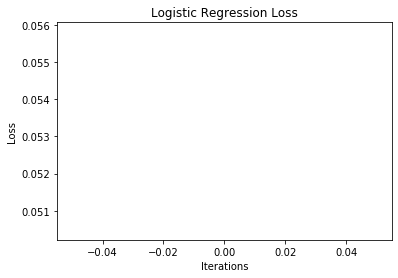

In [176]:
#load
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#initialize dimension and weights
dimensions = len( trainData[0].flatten() )    
w = np.zeros(dimensions + 1)

#hyperparameters
eta0 = 5 * (10 ** -3)
#eta1 = 10 ** -3
#eta2 = 10 ** -4
iterations = 5000
#test_iterations = 10

#other parameters
reg = 0
#reg0 = 0
#reg1 = 0.001
#reg2 = 0.01
#reg3 = 0.1
error_tol = 10 ** -7

w_optimal, costs = grad_descent(w, trainData, trainTarget, eta, iterations, reg, error_tol)

#other learning rates
#w_optimal1, costs1 = grad_descent(w, trainData, trainTarget, eta1, iterations, reg, error_tol)
#w_optimal2, costs2 = grad_descent(w, trainData, trainTarget, eta2, iterations, reg, error_tol)

#measure validation and test losses
#w_optimal_v, costs_v = grad_descent(w, validData, validTarget, eta, iterations, reg, error_tol)
#w_optimal_t, costs_t = grad_descent(w, testData, testTarget, eta, iterations, reg, error_tol)

#print final error
print(costs)

#plot
plt.plot(costs)
#plt.plot(costs1)
#plt.plot(costs2)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Logistic Regression Loss")

plt.show()

Briefly discuss the impact of $\eta$ on the training time. 

Answer:

$\eta$, or the learning rate, is a hyperparameter that determines the step size of each iteration in gradient descent. 

If the learning rate is too large, the training time is much shorter as the model can converge too quickly at a sub-optimal solution. 

If the learning rate is too small, the training time takes much longer and the model can stop converging; thus, the optimal parameters are never reached. It generally has a higher accuracy than a too-large learning rate.

The optimal learning is rate allows the model to reach the optimal minimum on the cost function and converges at the optimal parameters. The training time is between the too-large and too-small learning rate times, but the training accuracy will be much better. $\eta$ decreases with iterations.

### Generalization [3 points]:
Fix the learning rate to $\eta=0.005$, and consider values for the regularization parameter $\lambda = 0.001,\, 0.01,\, 0.1$. Measure the validation and test losses and state them in your answer below. Comment on the effect of regularization on performance as well as the rationale behind tuning $\eta$ using the validation set.

Training loss = approximately 0.0534 when $\eta = 0.005$
Training loss = approximately 0.0592 when $\eta = 0.01$
Training loss = approximately 0.0515 when $\eta = 0.001$

Note: I ran the above and graphed separately. This is because it took too long to make the graph hold on and plot all at the same time.

Below are the validation and test results when $\eta = 0.005$.

Validation losses:

For $\lambda = 0.001$: approximately 0.0602

For $\lambda = 0.01$: approximately 0.0614

For $\lambda = 0.1$: approximately 0.0622

Test losses:

For $\lambda = 0.001$: approximately 0.0713

For $\lambda = 0.01$: approximately 0.0721

For $\lambda = 0.1$: approximately 0.0728


The regularization parameter increases the performance of the model when generalizing on new data. This is because the regularization parameters acts as a constraint when determining the global minimum of the cost function.

Tuning the hyperparameter $\eta$, or the learning rate, allows the model to find the cost function global minimum most efficiently. This is done on the validation data set so the model can generalize better on the test data. In practice, training the model is done on the training data, hyperparameter tuning is done on the validation data, and testing is done on the testing data. 